In [1]:
#Imbalanced Classification Problem
#Import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

from decimal import *
getcontext().prec = 17

In [6]:
dataset1 = pd.read_excel("/Users/antonio/GitHub/ia/data.xlsx")
dataset1.head()

ID_studente  Genere  Diploma_scuola_sup  AreaGeografica_scuola_sup  \
0            1       1                   1                          3   
1            2       1                   1                          4   
2            3       1                   1                          4   
3            4       1                   1                          4   
4            5       1                   1                          3   

   Voto_scuola_sup  Voto_scuola_sup_classi  Età_immatricolazione  \
0            100.0                       1                     1   
1            100.0                       1                     1   
2            100.0                       1                     1   
3            100.0                       1                     1   
4            100.0                       1                     1   

   Situazione_OFA  Corso_di_studio_IDAggr  Scuola  Ciclo  Abbandoni  
0               1                     446       4      2          0  
1               1                     446       4      2          0  
2               2                     446       4      2          0  
3               1                     446       4      2          0  
4               2                     446       4      2          0

### Split test-training set

In [44]:
#Clean dataset
dataset = dataset1.drop(columns = ["ID_studente", "Voto_scuola_sup", "Situazione_OFA"] )

In [45]:
#The ratio of 0s to 1s is 1:7. This is a clear case of Imbalances class classification
X = dataset.drop('Abbandoni', axis=1)
y = dataset['Abbandoni']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [47]:
dataset.head()

Genere  Diploma_scuola_sup  AreaGeografica_scuola_sup  \
0       1                   1                          3   
1       1                   1                          4   
2       1                   1                          4   
3       1                   1                          4   
4       1                   1                          3   

   Voto_scuola_sup_classi  Età_immatricolazione  Corso_di_studio_IDAggr  \
0                       1                     1                     446   
1                       1                     1                     446   
2                       1                     1                     446   
3                       1                     1                     446   
4                       1                     1                     446   

   Scuola  Ciclo  Abbandoni  
0       4      2          0  
1       4      2          0  
2       4      2          0  
3       4      2          0  
4       4      2          0

# Importanza delle caratteristiche

### with Random Forests

In [52]:
# Addestrata una foresta di 10.000 alberi casuali sulle caratteristiche per misuarare la loro importanza
from sklearn.ensemble import RandomForestClassifier

feat_labels = dataset.columns[0:8]
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) Corso_di_studio_IDAggr         0.333437
 2) Voto_scuola_sup_classi         0.224699
 3) Diploma_scuola_sup             0.134046
 4) AreaGeografica_scuola_sup      0.100246
 5) Scuola                         0.098336
 6) Età_immatricolazione           0.058466
 7) Genere                         0.040588
 8) Ciclo                          0.010182


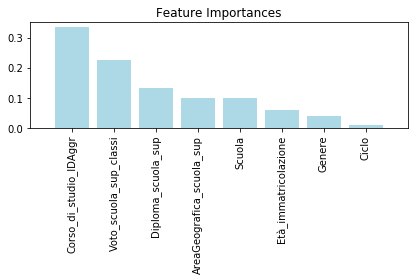

In [53]:
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

### with SBS (non ottimo, meglio la random forest a causa del non bilanciamento!)

In [54]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

/Users/antonio/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/antonio/anaconda2/lib/python2.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/antonio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


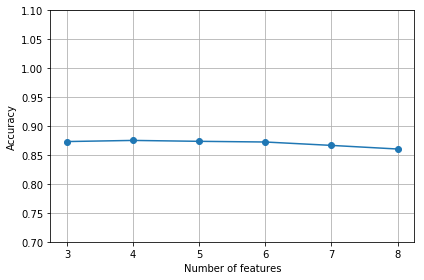

In [55]:
# Bring features to the same scale
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)


import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
sbs = SBS(knn, k_features=3)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [62]:
k5 = list(sbs.subsets_[5])
print(dataset.columns[0:8][k5])

Index([u'Genere', u'Diploma_scuola_sup', u'Scuola'], dtype='object')


In [63]:
k5

[0, 1, 6]